In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [2]:
# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27, 2)) # 把 27 个 characters embed 到 2维
# 论文原文是把 17000 words embed 到 30 维

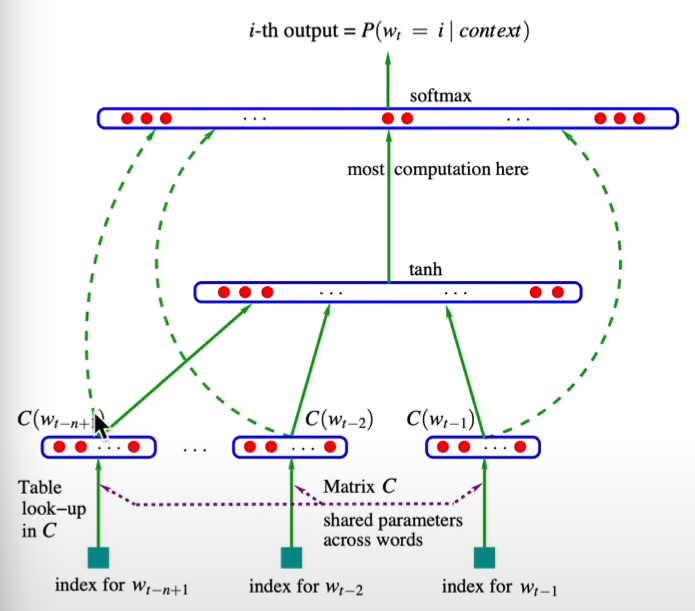

In [9]:
# 第一种思考方式：The integer indexing into a lookup table C
C[5]

tensor([0.4994, 0.9302])

In [10]:
# 第二种思考方式：想象成整个 NN 的 first layer, 这一层 layer 不含有 non-linearity (e.g. tanh), 
# 只包含 Linear neurons, 对应的 weight matrix 就是 C,
# 然后我们把 integer 通过 one hot encoder 之后，feed 进去，通过 C 来 embed 
# 第二种思考方式，把 C 当做 weights，这就可以通过 backpropogation 来学习
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.4994, 0.9302])

In [11]:
C[X].shape

torch.Size([32, 3, 2])

In [12]:
X[13,2]

tensor(1)

In [13]:
C[X][13,2]

tensor([-0.7617,  0.3296])

In [14]:
C[1]

tensor([-0.7617,  0.3296])

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [16]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concat 操作是 memory inefficient 的

torch.Size([32, 6])

In [17]:
torch.cat(torch.unbind(emb, 1), 1).shape
# 这是一个PyTorch代码片段，它使用`torch.unbind`函数将`emb`张量沿着第一个维度（列）解绑定成多个张量，然后使用`torch.cat`函数沿着第一个维度（列）将这些张量拼接起来，并获取拼接后的张量的形状。

torch.Size([32, 6])

In [19]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [82]:
W1 = torch.randn((6, 100)) # 6: 三个prev characters * 2dim/character; 100是一个超参数
b1 = torch.randn(100)

-1 通常用于 view 方法，它是 PyTorch 中的一种张量操作方法。具体来说，view 方法用于改变张量的形状。

当 -1 作为 view 方法的一个参数时，它表示 PyTorch 会根据其他维度的大小自动推断出这一维的大小。也就是说，-1 代表“我不知道这一维的大小，请根据其他维度的大小和总元素数来计算这一维的大小”。

例如，假设 emb 是一个形状为 (batch_size, 12) 的张量，如果我们调用 emb.view(-1, 6)，PyTorch 会将这个张量重新调整为形状 (batch_size * 2, 6)。这里的 -1 表示“自动计算这一维的大小”，而 6 是明确指定的大小。

In [83]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [84]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [85]:
b1.shape

torch.Size([100])

In [86]:
# broadcast
# 32, 100
#  1, 100


In [87]:
h.shape

torch.Size([32, 100])

In [76]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [77]:
logits = h @ W2 + b2

In [78]:
logits.shape

torch.Size([32, 27])

In [31]:
counts = logits.exp()

In [32]:
counts

tensor([[6.3061e+05, 5.3460e-03, 5.3118e+00, 1.1315e+00, 9.8291e-02, 7.9114e+04,
         4.1887e+06, 2.3430e+06, 1.9815e+09, 1.7454e-03, 1.9180e+00, 1.7583e+03,
         8.0550e+01, 2.1563e+03, 1.4478e+00, 7.7035e+00, 3.7840e-05, 9.2886e+04,
         1.3459e-04, 1.0389e-01, 7.6187e-09, 6.6459e-01, 1.8123e+00, 4.2010e+03,
         1.0866e-09, 3.8085e+02, 2.8307e-01],
        [1.0917e-03, 4.3857e-01, 6.4670e+02, 4.8157e-07, 1.4335e+02, 8.2695e-01,
         6.5837e+06, 6.1447e+01, 1.2750e+10, 1.2610e-06, 4.6400e+01, 6.0850e-01,
         2.6274e+01, 2.3448e+00, 5.6943e+04, 2.6675e-02, 2.4323e+01, 4.0480e+01,
         2.7776e-03, 1.2036e+01, 2.5228e-09, 2.0445e-04, 3.3575e-01, 5.9768e-03,
         1.1598e-09, 2.2475e-03, 2.2306e+05],
        [1.1653e-01, 4.9321e+00, 2.2516e+02, 2.1407e-03, 5.6335e+01, 3.8713e+01,
         2.7786e+03, 2.6615e-04, 4.8482e-03, 1.3233e-05, 8.9300e+00, 9.5882e-04,
         2.2652e-05, 2.0674e-01, 2.9613e+00, 1.3982e-05, 7.4267e+01, 7.8779e+01,
         3.1912e-

In [33]:
prob = counts / counts.sum(1, keepdims=True)

In [34]:
prob.shape

torch.Size([32, 27])

In [35]:
prob[0].sum()

tensor(1.)

In [36]:
Y  

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [38]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [42]:
prob

tensor([[3.1707e-04, 2.6880e-12, 2.6708e-09, 5.6890e-10, 4.9420e-11, 3.9779e-05,
         2.1061e-03, 1.1780e-03, 9.9631e-01, 8.7758e-13, 9.6438e-10, 8.8405e-07,
         4.0500e-08, 1.0842e-06, 7.2795e-10, 3.8733e-09, 1.9026e-14, 4.6703e-05,
         6.7674e-14, 5.2234e-11, 3.8307e-18, 3.3415e-10, 9.1121e-10, 2.1123e-06,
         5.4632e-19, 1.9149e-07, 1.4232e-10],
        [8.5578e-14, 3.4380e-11, 5.0695e-08, 3.7750e-17, 1.1237e-08, 6.4825e-11,
         5.1610e-04, 4.8168e-09, 9.9946e-01, 9.8853e-17, 3.6373e-09, 4.7700e-11,
         2.0596e-09, 1.8381e-10, 4.4638e-06, 2.0911e-12, 1.9067e-09, 3.1732e-09,
         2.1774e-13, 9.4354e-10, 1.9776e-19, 1.6027e-14, 2.6319e-11, 4.6852e-13,
         9.0916e-20, 1.7618e-13, 1.7485e-05],
        [8.4945e-06, 3.5951e-04, 1.6413e-02, 1.5604e-07, 4.1064e-03, 2.8219e-03,
         2.0254e-01, 1.9400e-08, 3.5340e-07, 9.6460e-10, 6.5093e-04, 6.9891e-08,
         1.6512e-09, 1.5070e-05, 2.1586e-04, 1.0192e-09, 5.4135e-03, 5.7424e-03,
         2.3261e-

In [43]:
prob[torch.arange(32)]

tensor([[3.1707e-04, 2.6880e-12, 2.6708e-09, 5.6890e-10, 4.9420e-11, 3.9779e-05,
         2.1061e-03, 1.1780e-03, 9.9631e-01, 8.7758e-13, 9.6438e-10, 8.8405e-07,
         4.0500e-08, 1.0842e-06, 7.2795e-10, 3.8733e-09, 1.9026e-14, 4.6703e-05,
         6.7674e-14, 5.2234e-11, 3.8307e-18, 3.3415e-10, 9.1121e-10, 2.1123e-06,
         5.4632e-19, 1.9149e-07, 1.4232e-10],
        [8.5578e-14, 3.4380e-11, 5.0695e-08, 3.7750e-17, 1.1237e-08, 6.4825e-11,
         5.1610e-04, 4.8168e-09, 9.9946e-01, 9.8853e-17, 3.6373e-09, 4.7700e-11,
         2.0596e-09, 1.8381e-10, 4.4638e-06, 2.0911e-12, 1.9067e-09, 3.1732e-09,
         2.1774e-13, 9.4354e-10, 1.9776e-19, 1.6027e-14, 2.6319e-11, 4.6852e-13,
         9.0916e-20, 1.7618e-13, 1.7485e-05],
        [8.4945e-06, 3.5951e-04, 1.6413e-02, 1.5604e-07, 4.1064e-03, 2.8219e-03,
         2.0254e-01, 1.9400e-08, 3.5340e-07, 9.6460e-10, 6.5093e-04, 6.9891e-08,
         1.6512e-09, 1.5070e-05, 2.1586e-04, 1.0192e-09, 5.4135e-03, 5.7424e-03,
         2.3261e-

In [37]:
prob[torch.arange(32), Y]

tensor([3.9779e-05, 1.8381e-10, 1.5070e-05, 5.9597e-05, 1.4940e-09, 3.8733e-09,
        7.0023e-08, 1.5211e-10, 1.7693e-13, 2.8279e-10, 1.2662e-12, 4.3334e-08,
        2.6880e-12, 9.0892e-10, 9.8166e-07, 2.6881e-09, 8.7758e-13, 9.3603e-12,
        2.7825e-09, 1.5384e-03, 3.8147e-07, 3.2201e-10, 3.1528e-07, 8.2758e-03,
        4.2412e-12, 5.2234e-11, 1.7858e-10, 1.5380e-08, 1.0000e+00, 1.5707e-10,
        2.2678e-10, 5.6555e-09])

In [44]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.7088)

In [45]:
# --------------- now made respectable :) ----------------
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [137]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [123]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [49]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss


tensor(17.7697)

In [50]:
logits = torch.tensor([-100, -3, 0, 100]) # 当 logits 太大的时候，exp就会出现 Inf 
counts = logits.exp()
probs = counts / counts.sum()

In [51]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [56]:
logits = torch.tensor([-5, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [55]:
logits = torch.tensor([-5, -3, 0, 5]) - 1 # logits 减去任意常数, 最后算出来的 prob 不变
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [ ]:
logits = torch.tensor([-5, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

In [132]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [146]:
lri = []
lossi = []

# 这一步确保所有参数都需要计算梯度。
for p in parameters:
    p.requires_grad = True

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())


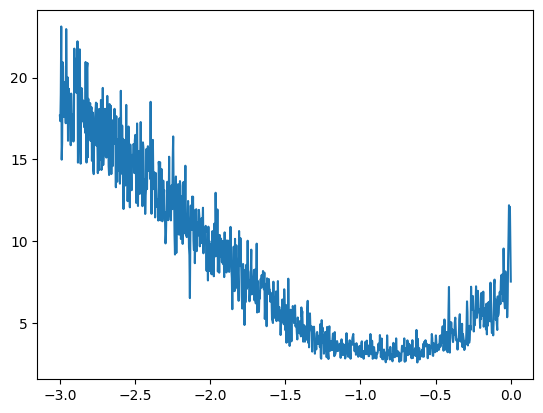

In [134]:
plt.plot(lri, lossi)

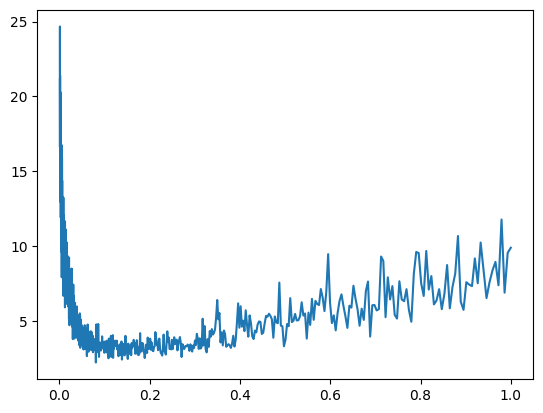

In [130]:
plt.plot(lri, lossi)

In [147]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.350764751434326


In [97]:
torch.randint(0, X.shape[0], (32, ))

tensor([ 72834,  29914,  27756,  55663, 109941,  86726,  54420, 183158,  68706,
         59520,  66695, 100707,   9631, 208251, 181751, 162521,  82579, 169014,
        181658,  78845,  66044, 163678, 120819, 174432,  96714,  68218, 139491,
        142599, 199104, 128459,  71088,  28339])

In [61]:
logits.shape

torch.Size([32, 27])

In [59]:
logits.max(1) # max along the first dimension

torch.return_types.max(
values=tensor([10.3765,  9.7808, 15.9531, 12.4269,  9.9291, 10.3765,  9.5849,  8.9140,
        12.1949, 13.1641,  9.6580, 15.8070, 10.3765, 10.6189, 10.8523, 12.6976,
        10.3765, 10.7718,  9.2004, 10.3824, 13.9289, 10.7242,  5.9444,  8.6032,
        12.9098, 10.3765, 10.8209, 11.4580,  8.9440, 13.7776, 11.3997,  9.6567],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 12, 13,  1, 15,  1, 12,  9,  9,  9,  1,  0,  1,  0,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  9,  0,  1, 15, 16,  8,  9,  1,  0]))

In [60]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [ ]:
# training split: train parameters
# dev/validation split: train hyper parameters
# test split: evaluate the performance of the model
# 80% 10% 10%

In [148]:
words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [50]:
block_size = 3 # context length: how many characters do we take to predict the next one?

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [51]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [52]:
sum(p.nelement() for p in parameters)

11897

In [53]:
# 这一步确保所有参数都需要计算梯度。
for p in parameters:
    p.requires_grad = True

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [55]:
lri = []
lossi = []
stepi = []

In [56]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 # if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


In [40]:
print(loss.item())


2.079869508743286


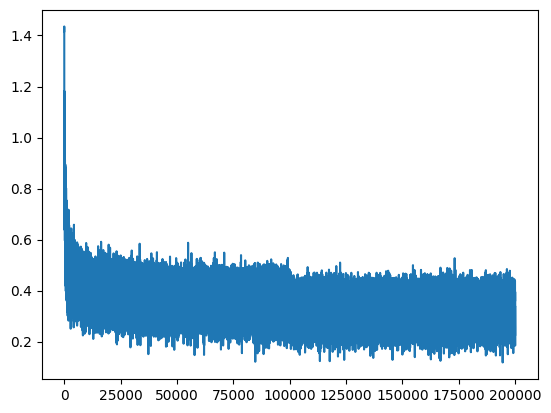

In [14]:
plt.plot(stepi, lossi)

In [15]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1252684593200684


In [16]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.166728973388672


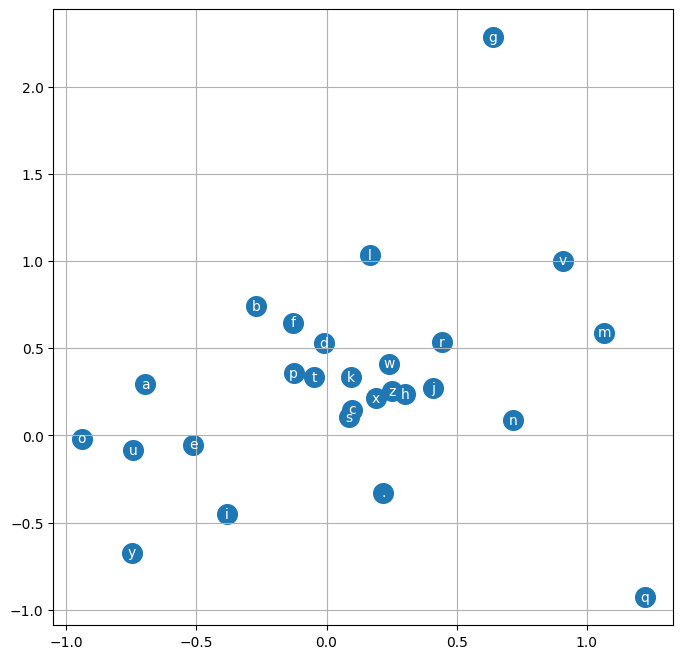

In [219]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


In [49]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        import pdb;pdb.set_trace()
        # 一般情况下（训练、valid、test）的时候，dim1的大小是train、valid、test set的数量
        # 这里dim1 等于1是因为我们只generate 1个名字，所以这里的dim1 = 1
        emb = C[torch.tensor([context])] # (1,block_size,d) 在这个例子中  torch.Size([1, 3, 10])
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


> c:\users\admin\appdata\local\temp\ipykernel_30656\1002732143.py(9)<module>()



ipdb>  context


*** The 'context' command requires a positive integer argument.


ipdb>  context


*** The 'context' command requires a positive integer argument.


ipdb>  [0] * block_size


[0, 0, 0]


ipdb>  p context


[0, 0, 0]


ipdb>  !context


[0, 0, 0]


ipdb>  C[torch.tensor([context])]


tensor([[[ 2.0764,  0.4343,  0.2868, -0.8920,  0.4692,  0.1565, -1.6465,
           0.5522,  0.7641,  0.8960],
         [ 2.0764,  0.4343,  0.2868, -0.8920,  0.4692,  0.1565, -1.6465,
           0.5522,  0.7641,  0.8960],
         [ 2.0764,  0.4343,  0.2868, -0.8920,  0.4692,  0.1565, -1.6465,
           0.5522,  0.7641,  0.8960]]], grad_fn=<IndexBackward0>)


ipdb>  C[torch.tensor([context])].shape


torch.Size([1, 3, 10])


ipdb>  q
